<a href="https://colab.research.google.com/github/mldl2020/FirstPersonActionRecognition/blob/master/FirstPersonActionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [0]:
if(False):
  #!pip3 install 'torch==1.3.1'
  !pip3 install 'torch==1.4.0'
  !pip3 install 'torchvision==0.5.0'
  !pip3 install 'Pillow-SIMD'
  !pip3 install 'tqdm'


**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import resnet34

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 61 

BATCH_SIZE = 32     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
MEM_SIZE = 512

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
ALPHA = 0.5

LOG_FREQUENCY = 10
VAL_FREQUENCY = 3

In [0]:
# Clone github repository with data
if not os.path.isdir('./GTEA61'):
  !git clone https://github.com/MauriVass/GTEA61

#Remove file to avoid problems with 'makeDatasetTwoStream()'
import shutil
if os.path.isdir('GTEA61/.git'):
  shutil.rmtree('GTEA61/.git')
  os.remove('GTEA61/.gitignore')
  
PATH_MODELS = 'Models/'
if not os.path.isdir('./'+PATH_MODELS):
  os.mkdir('./'+PATH_MODELS)

Cloning into 'GTEA61'...
remote: Enumerating objects: 9639, done.
remote: Counting objects: 100% (9639/9639), done.
remote: Compressing objects: 100% (9566/9566), done.
remote: Total 93346 (delta 25), reused 9577 (delta 8), pack-reused 83707
Receiving objects: 100% (93346/93346), 4.21 GiB | 31.77 MiB/s, done.
Resolving deltas: 100% (1493/1493), done.
Checking out files: 100% (90815/90815), done.


In [0]:
def PlotAccuracyLoss(train, valid, meta=''):
  acc_train = np.array(train)[:,0]
  loss_train = np.array(train)[:,1]

  if(valid):
    acc_valid = np.array(valid)[:,0]
    loss_valid = np.array(valid)[:,1]

  epoch_train = [i for i in range(len(acc_train))]
  if(valid):
    epoch_val = [i*VAL_FREQUENCY for i in range(len(acc_valid))]

  fig, ax = plt.subplots(1,2,figsize=(13,7))
  size = 10

  color_train = '#ff0000'
  color_val = '#00ff00'

  ax[0].plot(epoch_train,loss_train,color=color_train)
  ax[0].scatter(epoch_train,loss_train,marker='s',s=size,color=color_train)
  if(valid):
    ax[0].plot(epoch_val,loss_valid,color=color_val)
    ax[0].scatter(epoch_val,loss_valid,marker='s',s=size,color=color_val)
  ax[0].set_title('Loss Graph')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')

  ax[1].plot(epoch_train,acc_train,color=color_train)
  ax[1].scatter(epoch_train,acc_train,marker='s',s=size,color=color_train)
  if(valid):
    ax[1].plot(epoch_val,acc_valid,color=color_val)
    ax[1].scatter(epoch_val,acc_valid,marker='s',s=size,color=color_val)
  ax[1].set_title('Accuracy Graph')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')

  fig.suptitle(meta)
  plt.legend(["Train", "Validation"])

  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

  if(valid):
    print('Min Loss: Train: {:.6f}, Val: {:.6f}'.format( min(loss_train), min(loss_valid) ))
    print('Max Accuracy: Train: {:.6f}, Val: {:.6f}'.format( max(acc_train), max(acc_valid) ))
  else:
    print('Min Loss: Train: {:.6f}'.format( min(loss_train) ))
    print('Max Accuracy: Train: {:.6f}'.format( max(acc_train) ))

# ConvLSTM

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, MEM_SIZE, kernel_size=5)
    self.conv2 = nn.Conv2d(MEM_SIZE, MEM_SIZE, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(MEM_SIZE, 50)
    self.fc2 = nn.Linear(50, NUM_CLASSES)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    #x = F.relu(self.fc1(x))
    #x = F.dropout(x, training=self.training)
    #x = self.fc2(x)
    #return F.log_softmax(x, dim=1)
    return x

class Combine(nn.Module):
  def __init__(self):
    super(Combine, self).__init__()
    self.cnn = CNN()
    self.rnn = nn.LSTM(
      input_size=320, 
      hidden_size=64, 
      num_layers=1,
      batch_first=True)
    self.linear = nn.Linear(64,10)

  def forward(self, x):
    batch_size, timesteps, C, H, W = x.size()
    c_in = x.view(batch_size * timesteps, C, H, W)
    c_out = self.cnn(c_in)
    r_in = c_out.view(batch_size, timesteps, -1)
    r_out, (h_n, h_c) = self.rnn(r_in)
    r_out2 = self.linear(r_out[:, -1, :])
    
    return F.log_softmax(r_out2, dim=1)

In [0]:
from MakeDatasetRGB import *
from spatial_transforms import *
from objectAttentionModelConvLSTM import *

normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = Compose([Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224),
                                 ToTensor(), normalize])
    
DIR = 'GTEA61/processed_frames2' 
seqLen = 7
training_folders = [1,3,4]
train_dataset = makeDatasetRGB(DIR, spatial_transform=spatial_transform, seqLen=seqLen, fmt='.png', folders=training_folders)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

val_transform = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])
validation = False
if(validation):
  validation_folders = [3]
  val_dataset = makeDatasetRGB(DIR, spatial_transform=val_transform , seqLen=seqLen, fmt='.png', folders=validation_folders)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)


testing_folders = [2]
test_dataset = makeDatasetRGB(DIR, spatial_transform=val_transform, seqLen=seqLen, fmt='.png', folders=testing_folders)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)


In [0]:
NUM_EPOCHS = 3
lr = 1e-3
decay_step = [25, 75, 150]
decay_factor = 0.1

model = Combine()
model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()

optimizer_fn = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=4e-5, eps=1e-4)

optim_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=decay_step, gamma=decay_factor)

TypeError: ignored

In [0]:
model.train()
for batch_idx, (data, target) in enumerate(train_loader):
    
  #data = np.expand_dims(data, axis=1)
  data = torch.FloatTensor(data)
  print(data.size())
  data, target = Variable(data.to(DEVICE)), target.cuda()
  print(data.size())
  data, target = Variable(data), Variable(target)
  optimizer_fn.zero_grad()
  print(data.size())
  output = model(data)
  
  loss = F.nll_loss(output, target)
  loss.backward()
  optimizer_fn.step()
  if batch_idx % args.log_interval == 0:
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(train_loader.dataset),
      100. * batch_idx / len(train_loader), loss.data()))

torch.Size([32, 7, 3, 224, 224])
torch.Size([32, 7, 3, 224, 224])
torch.Size([32, 7, 3, 224, 224])


RuntimeError: ignored

# ConvLSTM-Attention

In [0]:
from MakeDatasetRGB import *
from spatial_transforms import *
from objectAttentionModelConvLSTM import *

normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = Compose([Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224),
                                 ToTensor(), normalize])
    
DIR = 'GTEA61/processed_frames2' 
seqLen = 7
training_folders = [1,3,4]
train_dataset = makeDatasetRGB(DIR, spatial_transform=spatial_transform, seqLen=seqLen, fmt='.png', folders=training_folders)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

val_transform = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])
validation = False
if(validation):
  validation_folders = [3]
  val_dataset = makeDatasetRGB(DIR, spatial_transform=val_transform , seqLen=seqLen, fmt='.png', folders=validation_folders)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)


testing_folders = [2]
test_dataset = makeDatasetRGB(DIR, spatial_transform=val_transform, seqLen=seqLen, fmt='.png', folders=testing_folders)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)


In [0]:
def PrepareTraining(stage, path=''):
  train_params = []
  if stage == 1:

      model = attentionModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE)
      model.train(False)
      for params in model.parameters():
          params.requires_grad = False
  else:

      model = attentionModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE)
      stage1_dict = path
      model.load_state_dict(torch.load(stage1_dict))
      model.train(False)
      for params in model.parameters():
          params.requires_grad = False
      #
      for params in model.resNet.layer4[0].conv1.parameters():
          params.requires_grad = True
          train_params += [params]

      for params in model.resNet.layer4[0].conv2.parameters():
          params.requires_grad = True
          train_params += [params]

      for params in model.resNet.layer4[1].conv1.parameters():
          params.requires_grad = True
          train_params += [params]

      for params in model.resNet.layer4[1].conv2.parameters():
          params.requires_grad = True
          train_params += [params]

      for params in model.resNet.layer4[2].conv1.parameters():
          params.requires_grad = True
          train_params += [params]
      #
      for params in model.resNet.layer4[2].conv2.parameters():
          params.requires_grad = True
          train_params += [params]
      #
      for params in model.resNet.fc.parameters():
          params.requires_grad = True
          train_params += [params]

      model.resNet.layer4[0].conv1.train(True)
      model.resNet.layer4[0].conv2.train(True)
      model.resNet.layer4[1].conv1.train(True)
      model.resNet.layer4[1].conv2.train(True)
      model.resNet.layer4[2].conv1.train(True)
      model.resNet.layer4[2].conv2.train(True)
      model.resNet.fc.train(True)

  for params in model.lstm_cell.parameters():
      params.requires_grad = True
      train_params += [params]

  for params in model.classifier.parameters():
      params.requires_grad = True
      train_params += [params]

  return model, train_params

In [0]:
stage = 1
NUM_EPOCHS = 200
lr1 = 1e-3
decay_step = [25, 75, 150]
decay_factor = 0.1

model, train_params = PrepareTraining(stage)

model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer_fn = torch.optim.Adam(train_params, lr=lr1, weight_decay=4e-5, eps=1e-4)
optim_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=decay_step, gamma=decay_factor)

TRAINING (STAGE 1)

In [0]:
def TrainingRGB():
  train_iter = 0
  min_accuracy = 0

  train = []
  val = []
  best_acc = -1
  for epoch in range(NUM_EPOCHS):
      epoch_loss = 0
      numCorrTrain = 0
      trainSamples = 0
      iterPerEpoch = 0
      model.lstm_cell.train(True)
      model.classifier.train(True)
      #writer.add_scalar('lr', optimizer_fn.param_groups[0]['lr'], epoch+1)
      if stage == 2:
          model.resNet.layer4[0].conv1.train(True)
          model.resNet.layer4[0].conv2.train(True)
          model.resNet.layer4[1].conv1.train(True)
          model.resNet.layer4[1].conv2.train(True)
          model.resNet.layer4[2].conv1.train(True)
          model.resNet.layer4[2].conv2.train(True)
          model.resNet.fc.train(True)
      for i, (inputs, targets) in enumerate(train_loader):
          train_iter += 1
          iterPerEpoch += 1
          optimizer_fn.zero_grad()
          print(inputs.size())
          inputVariable = Variable(inputs.permute(1, 0, 2, 3, 4).to(DEVICE))
          print(inputVariable.size())
          break
          labelVariable = Variable(targets.to(DEVICE))
          trainSamples += inputs.size(0)
          output_label, _ = model(inputVariable)
          loss = loss_fn(output_label, labelVariable)
          loss.backward()
          optimizer_fn.step()
          _, predicted = torch.max(output_label.data, 1)

          predicted = predicted.to(DEVICE)
          numCorrTrain += torch.sum(predicted == labelVariable).data.item()
          
          #numCorrTrain += (predicted == targets.cuda()).sum()
          epoch_loss += loss.item()
      avg_loss = epoch_loss/iterPerEpoch
      trainAccuracy = (numCorrTrain / trainSamples)

      print('Train: Epoch = {}/{} | Loss = {} | Accuracy = {}'.format(epoch+1, NUM_EPOCHS, avg_loss, trainAccuracy))

      max_loss = 6
      avg_loss_normalized = avg_loss if avg_loss < max_loss else max_loss
      train.append( (trainAccuracy,avg_loss_normalized) )

      optim_scheduler.step()
      #writer.add_scalar('train/epoch_loss', avg_loss, epoch+1)
      #writer.add_scalar('train/accuracy', trainAccuracy, epoch+1)      
      
      if(validation):
        if(epoch+1) % VAL_FREQUENCY == 0:
          model.train(False)
          val_loss_epoch = 0
          val_iter = 0
          val_samples = 0
          numCorr = 0
          for j, (inputs, targets) in enumerate(val_loader):
            val_iter += 1
            val_samples += inputs.size(0)
            inputVariable = Variable(inputs.permute(1, 0, 2, 3, 4).cuda(), volatile=True)
            labelVariable = Variable(targets.cuda(async=True), volatile=True)
            output_label, _ = model(inputVariable)
            val_loss = loss_fn(output_label, labelVariable)
            val_loss_epoch += val_loss.item()
            _, predicted = torch.max(output_label.data, 1)
            numCorr += torch.sum(predicted == labelVariable).data.item()
          val_accuracy = (numCorr / val_samples)
          avg_val_loss = val_loss_epoch / val_iter
          print('*****  Val: Epoch = {} | Loss {} | Accuracy = {} *****'.format(epoch + 1, avg_val_loss, val_accuracy))

          avg_val_loss_normalized = avg_val_loss if avg_val_loss < max_loss else max_loss
          val.append( (val_accuracy,avg_val_loss_normalized) )
          #writer.add_scalar('val/epoch_loss', avg_val_loss, epoch + 1)
          #writer.add_scalar('val/accuracy', val_accuracy, epoch + 1)
          #val_log_loss.write('Val Loss after {} epochs = {}\n'.format(epoch + 1, avg_val_loss))
          #val_log_acc.write('Val Accuracy after {} epochs = {}%\n'.format(epoch + 1, val_accuracy))
          if val_accuracy > min_accuracy:
            save_path_model = (PATH_MODELS + '/best_model_rgb_state_dict.pth')
            torch.save(model.state_dict(), save_path_model)
            min_accuracy = val_accuracy
      
      if (numCorrTrain>best_acc):
        best_acc = numCorrTrain
        save_path_model = (PATH_MODELS + '/model_rgb_state_dict_epoch' + '_stage' + str(stage) + '.pth')
        torch.save(model.state_dict(), save_path_model)
          
  return train, val

In [0]:
train_rgb, val_rgb = TrainingRGB()

torch.Size([32, 7, 3, 224, 224])
torch.Size([7, 32, 3, 224, 224])


ZeroDivisionError: ignored

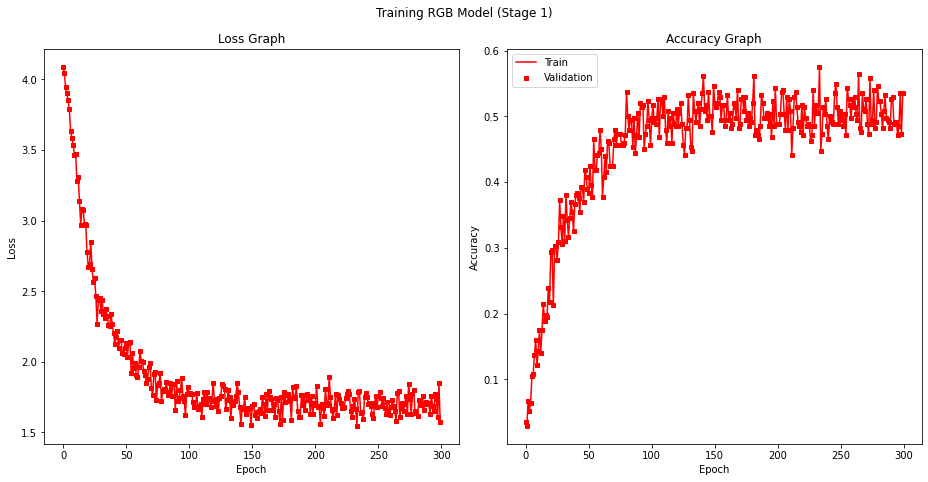

Min Loss: Train: 1.545733
Max Accuracy: Train: 0.575581


In [0]:
meta_rgb = 'Training RGB Model (Stage 1)'
PlotAccuracyLoss(train_rgb, val_rgb, meta_rgb)

In [0]:
from sklearn.metrics import confusion_matrix
def TestRGB(model):
  for params in model.parameters():
      params.requires_grad = False

  model.train(False)
  model.to(DEVICE)
  test_samples = test_dataset.__len__()
  print('Number of samples = {}'.format(test_samples))
  print('Evaluating...')
  numCorr = 0
  true_labels = []
  predicted_labels = []
  for j, (inputs, targets) in enumerate(test_loader):
    inputVariable = Variable(inputs.permute(1, 0, 2, 3, 4).to(DEVICE), volatile=True)
    output_label, _ = model(inputVariable)
    _, predicted = torch.max(output_label.data, 1)
    predicted = predicted.to(DEVICE)
    numCorr += torch.sum(predicted == targets.to(DEVICE)).data.item()
    true_labels.append(targets)
    predicted_labels.append(predicted)
  test_accuracy = (numCorr / test_samples)
  print('Test Accuracy = {}%'.format(test_accuracy))

  cnf_matrix = confusion_matrix([f.item() for f in true_labels], [f.item() for f in predicted_labels]).astype(float)
  cnf_matrix_normalized = cnf_matrix / cnf_matrix.sum(axis=1)[:, np.newaxis]

  ticks = np.linspace(0, 60, num=61)
  plt.imshow(cnf_matrix_normalized, interpolation='none', cmap='binary')
  plt.colorbar()
  plt.xticks(ticks, fontsize=6)
  plt.yticks(ticks, fontsize=6)
  plt.grid(True)
  plt.clim(0, 1)
  #plt.savefig('-rgb.png', bbox_inches='tight')
  plt.show()

Number of samples = 113
Evaluating...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Test Accuracy = 0.4424778761061947%


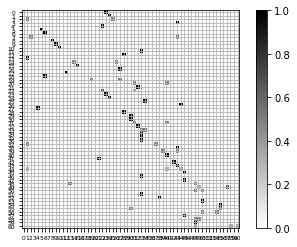

In [0]:
model = attentionModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE)
#model_state_dict = PATH_MODELS + '/best_model_rgb_state_dict.pth'
model_state_dict = PATH_MODELS + '/model_rgb_state_dict_epoch_stage1_90.pth'

model.load_state_dict(torch.load(model_state_dict))
TestRGB(model)

TRAINING (STAGE 2)

In [0]:
stage = 2
NUM_EPOCHS = 150
lr2 = 1e-4
decay_step2 = [25, 75]
decay_factor2 = 0.1

model, train_params2 = PrepareTraining(stage, model_state_dict)

model.lstm_cell.train(True)

model.classifier.train(True)
model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()

optimizer_fn = torch.optim.Adam(train_params2, lr=lr2, weight_decay=4e-5, eps=1e-4)

optim_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=decay_step2, gamma=decay_factor2)

In [0]:
train_rgb, val_rgb = TrainingRGB()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train: Epoch = 1/150 | Loss = 2.215390367941423 | Accuracy = 0.3866279069767442
Train: Epoch = 2/150 | Loss = 2.069909518415278 | Accuracy = 0.39825581395348836
Train: Epoch = 3/150 | Loss = 2.037191217595881 | Accuracy = 0.3808139534883721
Train: Epoch = 4/150 | Loss = 2.09550095688213 | Accuracy = 0.42151162790697677
Train: Epoch = 5/150 | Loss = 1.9730462486093694 | Accuracy = 0.436046511627907
Train: Epoch = 6/150 | Loss = 1.931714112108404 | Accuracy = 0.45348837209302323
Train: Epoch = 7/150 | Loss = 1.8807660341262817 | Accuracy = 0.4563953488372093
Train: Epoch = 8/150 | Loss = 1.9119016148827293 | Accuracy = 0.47674418604651164
Train: Epoch = 9/150 | Loss = 1.797388802875172 | Accuracy = 0.48255813953488375
Train: Epoch = 10/150 | Loss = 1.8243343288248235 | Accuracy = 0.45930232558139533
Train: Epoch = 11/150 | Loss = 1.9044554883783513 | Accuracy = 0.46511627906976744
Train: Epoch = 12/150 | Loss = 1.8195513920350508 | Accuracy = 0.4680232558139535
Train: Epoch = 13/150 | Lo

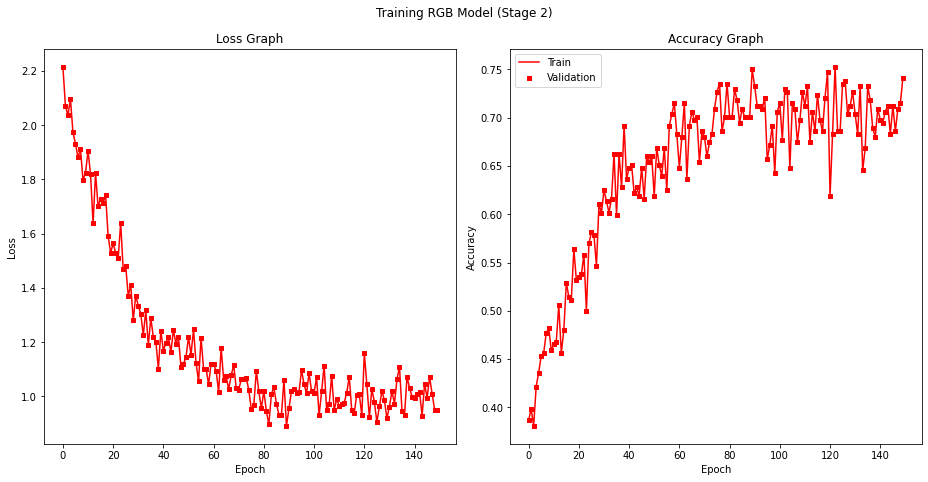

Min Loss: Train: 0.891735
Max Accuracy: Train: 0.752907


In [0]:
meta_rgb = 'Training RGB Model (Stage 2)'
PlotAccuracyLoss(train_rgb, val_rgb, meta_rgb)

Number of samples = 113
Evaluating...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Test Accuracy = 0.4424778761061947%


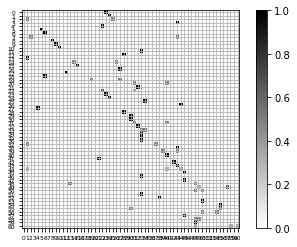

In [0]:
TestRGB(model)

# Temporal-WarpFlow

In [0]:
from MakeDatasetFlow import *
from spatial_transforms import *
from objectAttentionModelConvLSTM import *


stackSize = 5
BATCH_SIZE = 32
NUM_EPOCHS = 50 #750
lr = 1e-2
decay_step = [150, 300, 500]
decay_factor = 0.5
numSeg = 1

normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = Compose([Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224),
                                 ToTensor(), normalize])
    
DIR = 'GTEA61/flow_x_processed' 
training_folders = [1,3,4]
train_dataset = makeDatasetFlow(DIR, spatial_transform=spatial_transform, stackSize=stackSize, sequence=False, numSeg=numSeg, fmt='.png', folders=training_folders)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, sampler=None, num_workers=4, pin_memory=True)

val_transform = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])
if(validation):
  validation_folders = [3]
  val_dataset = makeDatasetFlow(DIR, spatial_transform=val_transform , stackSize=stackSize, sequence=False, numSeg=numSeg, fmt='.png', folders=validation_folders, phase='Test')
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


test_transform = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])
testing_folders = [2]
test_dataset = makeDatasetFlow(DIR, spatial_transform=val_transform, stackSize=stackSize, sequence=False, numSeg=numSeg, fmt='.png', folders=testing_folders, phase='Test')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)


In [0]:
from flow_resnet import flow_resnet34

model = flow_resnet34(True, channels=2*stackSize, num_classes=NUM_CLASSES)
#model_state_dict = PATH_MODELS + 'best_model_state_dict_flow_split2.pth'
#model.load_state_dict(torch.load(model_state_dict))
model.train(True)
train_params = list(model.parameters())
model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer_fn = torch.optim.SGD(train_params, lr=lr, momentum=0.9, weight_decay=5e-4)
optim_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=decay_step, gamma=decay_factor)

In [0]:
def TrainingFlow():
  train_iter = 0
  min_accuracy = 0

  train = []
  val = []
  best_acc = -1
  for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    numCorrTrain = 0
    trainSamples = 0
    iterPerEpoch = 0
    model.train(True)
    #writer.add_scalar('lr', optimizer_fn.param_groups[0]['lr'], epoch+1)
    for i, (inputs, targets) in enumerate(train_loader):
      train_iter += 1
      iterPerEpoch += 1
      optimizer_fn.zero_grad()
      inputVariable = Variable(inputs.to(DEVICE))
      labelVariable = Variable(targets.to(DEVICE))
      trainSamples += inputs.size(0)
      output_label, _ = model(inputVariable)
      loss = loss_fn(output_label, labelVariable)
      loss.backward()
      optimizer_fn.step()
      _, predicted = torch.max(output_label.data, 1)
      numCorrTrain += torch.sum(predicted == targets.to(DEVICE)).data.item()
      epoch_loss += loss.item()
    avg_loss = epoch_loss/iterPerEpoch
    trainAccuracy = (numCorrTrain / trainSamples)
    print('Train: Epoch = {}/{} | Loss = {} | Accuracy = {}'.format(epoch + 1, NUM_EPOCHS, avg_loss, trainAccuracy))

    max_loss = 6
    avg_loss_normalized = avg_loss if avg_loss < max_loss else max_loss
    train.append( (trainAccuracy,avg_loss_normalized) )

    optim_scheduler.step()
    #writer.add_scalar('train/epoch_loss', avg_loss, epoch+1)
    #writer.add_scalar('train/accuracy', trainAccuracy, epoch+1)
    #train_log_loss.write('Training loss after {} epoch = {}\n'.format(epoch+1, avg_loss))
    #train_log_acc.write('Training accuracy after {} epoch = {}\n'.format(epoch+1, trainAccuracy))
    if(validation):
      if (epoch+1) % VAL_FREQUENCY == 0:
        model.train(False)
        val_loss_epoch = 0
        val_iter = 0
        val_samples = 0
        numCorr = 0
        for j, (inputs, targets) in enumerate(val_loader):
          val_iter += 1
          val_samples += inputs.size(0)
          inputVariable = Variable(inputs.cuda(), volatile=True)
          labelVariable = Variable(targets.cuda(async=True), volatile=True)
          output_label, _ = model(inputVariable)
          val_loss = loss_fn(output_label, labelVariable)
          val_loss_epoch += val_loss.item()
          _, predicted = torch.max(output_label.data, 1)
          numCorr += torch.sum(predicted == targets.to(DEVICE)).data.item()
        val_accuracy = (numCorr / val_samples)
        avg_val_loss = val_loss_epoch / val_iter
        print('*****  Validation: Epoch = {} | Loss = {} | Accuracy = {}  *****'.format(epoch + 1, avg_val_loss, val_accuracy))
        avg_val_loss_normalized = avg_val_loss if avg_val_loss < max_loss else max_loss
        val.append( (val_accuracy,avg_val_loss_normalized) )
        #writer.add_scalar('val/epoch_loss', avg_val_loss, epoch + 1)
        #writer.add_scalar('val/accuracy', val_accuracy, epoch + 1)
        #val_log_loss.write('Val Loss after {} epochs = {}\n'.format(epoch + 1, avg_val_loss))
        #val_log_acc.write('Val Accuracy after {} epochs = {}%\n'.format(epoch + 1, val_accuracy))
        if val_accuracy > min_accuracy:
          save_path_model = (PATH_MODELS + '/best_model_flow_state_dict.pth')
          torch.save(model.state_dict(), save_path_model)
          min_accuracy = val_accuracy

    if (numCorrTrain>best_acc):
      best_acc = numCorrTrain
      save_path_model = (PATH_MODELS + '/model_flow_state_dict_epoch' + '.pth')
      torch.save(model.state_dict(), save_path_model)

  return train, val

In [0]:
train_flow, val_flow = TrainingFlow()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: Epoch = 1/50 | Loss = 1.9942046850919724 | Accuracy = 0.5
Train: Epoch = 2/50 | Loss = 2.9282103180885315 | Accuracy = 0.34649122807017546
Train: Epoch = 3/50 | Loss = 3.23906546831131 | Accuracy = 0.21052631578947367


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


*****  Validation: Epoch = 3 | Loss = 10.280046343803406 | Accuracy = 0.08620689655172414  *****
Train: Epoch = 4/50 | Loss = 3.4844000935554504 | Accuracy = 0.19298245614035087
Train: Epoch = 5/50 | Loss = 3.333032250404358 | Accuracy = 0.14912280701754385
Train: Epoch = 6/50 | Loss = 3.2639679610729218 | Accuracy = 0.14912280701754385
*****  Validation: Epoch = 6 | Loss = 6.94232565164566 | Accuracy = 0.16379310344827586  *****
Train: Epoch = 7/50 | Loss = 3.3862711787223816 | Accuracy = 0.17105263157894737
Train: Epoch = 8/50 | Loss = 3.224565863609314 | Accuracy = 0.19736842105263158
Train: Epoch = 9/50 | Loss = 3.091442048549652 | Accuracy = 0.22807017543859648
*****  Validation: Epoch = 9 | Loss = 3.224925398826599 | Accuracy = 0.14655172413793102  *****
Train: Epoch = 10/50 | Loss = 3.277636080980301 | Accuracy = 0.16228070175438597
Train: Epoch = 11/50 | Loss = 3.0292997658252716 | Accuracy = 0.2149122807017544
Train: Epoch = 12/50 | Loss = 3.0520905554294586 | Accuracy = 0.171

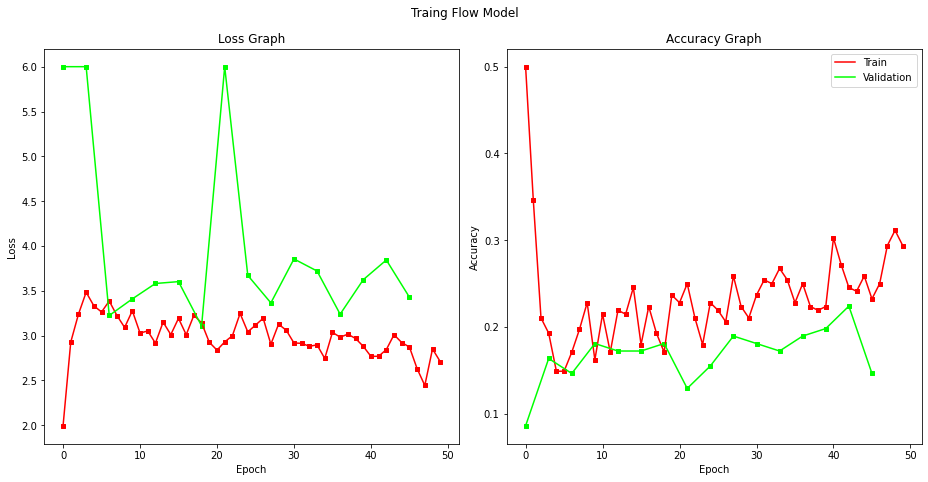

Min Loss: Train: 1.994205, Val: 3.108306
Max Accuracy: Train: 0.500000, Val: 0.224138


In [0]:
meta_flow = 'Training Flow Model'
PlotAccuracyLoss(train_flow, val_flow, meta_flow)

In [0]:
from sklearn.metrics import confusion_matrix
def Test():

  for params in model.parameters():
      params.requires_grad = False

  model.train(False)
  model.to(DEVICE)
  test_samples = val_dataset.__len__()
  print('Number of samples = {}'.format(test_samples))
  print('Evaluating...')
  numCorr = 0
  true_labels = []
  predicted_labels = []
  for j, (inputs, targets) in enumerate(test_loader):
    inputVariable = Variable(inputs.to(DEVICE), volatile=True)
    output_label, _ = model(inputVariable)
    output_label_mean = torch.mean(output_label.data, 0, True)
    _, predicted = torch.max(output_label.data, 1)
    predicted = predicted.to(DEVICE)
    numCorr += torch.sum(predicted == targets.to(DEVICE)).data.item()
    #numCorr += (predicted == targets.to(DEVICE)).sum()
    true_labels.append(targets)
    predicted_labels.append(predicted)
  test_accuracy = (numCorr / test_samples)
  print('Test Accuracy = {}%'.format(test_accuracy))

  #cnf_matrix = confusion_matrix(true_labels, predicted_labels).astype(float)
  cnf_matrix = confusion_matrix([f.item() for f in true_labels], [f.item() for f in predicted_labels]).astype(float)
  cnf_matrix_normalized = cnf_matrix / cnf_matrix.sum(axis=1)[:, np.newaxis]

  ticks = np.linspace(0, 60, num=61)
  plt.imshow(cnf_matrix_normalized, interpolation='none', cmap='binary')
  plt.colorbar()
  plt.xticks(ticks, fontsize=6)
  plt.yticks(ticks, fontsize=6)
  plt.grid(True)
  plt.clim(0, 1)
  #plt.savefig('-rgb.png', bbox_inches='tight')
  plt.show()

Number of samples = 116
Evaluating...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


Test Accuracy = 0.10344827586206896%


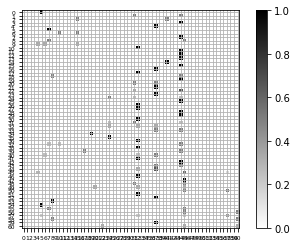

In [0]:
model = flow_resnet34(True, channels=2*stackSize, num_classes=NUM_CLASSES)
#model_state_dict = PATH_MODELS + 'best_model_state_dict_flow_split2.pth' 
model_state_dict = PATH_MODELS + '/best_model_flow_state_dict.pth'
model.load_state_dict(torch.load(model_state_dict))
Test()

# Two-Stream (Joint Train)

In [0]:
from MakeDatasetTwoStream import *
from spatial_transforms import *
from objectAttentionModelConvLSTM import *

MEM_SIZE = 512
numSeg = 16
stackSize = 5
lr = 1e-2
decay_step = 1
decay_factor = 0.99
NUM_EPOCHS = 250


normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = Compose([Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224),
                                 ToTensor(), normalize])

DIR = 'GTEA61' 
training_folders = [1,3,4]
train_dataset = makeDatasetTwoStream(DIR, spatial_transform=spatial_transform, stackSize=stackSize, numSeg=numSeg, fmt='.png', folders=training_folders)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

val_transform = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])
validation = False
if(validation):
  validation_folders = [3]
  val_dataset = makeDatasetTwoStream(DIR, spatial_transform=val_transform , stackSize=stackSize, numSeg=numSeg, fmt='.png', folders=validation_folders)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)


test_transform = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])
testing_folders = [2]
test_dataset = makeDatasetTwoStream(DIR, spatial_transform=val_transform, stackSize=stackSize, numSeg=numSeg, fmt='.png', folders=testing_folders)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)


In [0]:
from flow_resnet import flow_resnet34
from objectAttentionModelConvLSTM import *
from twoStreamModel import *

#flowModel = flow_resnet34(True, channels=2*stackSize, num_classes=NUM_CLASSES)
#model_state_dict = PATH_MODELS + 'best_model_state_dict_flow_split2.pth'
flow_model_path = PATH_MODELS + 'best_model_state_dict_flow_split2.pth'
#flowModel.load_state_dict(torch.load(model_state_dict))

#rgbModel = attentionModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE)
#stage1_dict = PATH_MODELS + '/best_model_rgb_state_dict.pth'
rgb_model_path = PATH_MODELS + 'best_model_state_dict_rgb_split2.pth'
#rgbModel.load_state_dict(torch.load(stage1_dict))


model = twoStreamAttentionModel(flowModel=flow_model_path, frameModel=rgb_model_path, stackSize=stackSize, memSize=MEM_SIZE, num_classes=NUM_CLASSES)

for params in model.parameters():
  params.requires_grad = False

model.train(False)
train_params = []

for params in model.classifier.parameters():
  params.requires_grad = True
  train_params += [params]

for params in model.frameModel.lstm_cell.parameters():
  train_params += [params]
  params.requires_grad = True

for params in model.frameModel.resNet.layer4[0].conv1.parameters():
  params.requires_grad = True
  train_params += [params]

for params in model.frameModel.resNet.layer4[0].conv2.parameters():
  params.requires_grad = True
  train_params += [params]

for params in model.frameModel.resNet.layer4[1].conv1.parameters():
  params.requires_grad = True
  train_params += [params]

for params in model.frameModel.resNet.layer4[1].conv2.parameters():
  params.requires_grad = True
  train_params += [params]

for params in model.frameModel.resNet.layer4[2].conv1.parameters():
  params.requires_grad = True
  train_params += [params]
#
for params in model.frameModel.resNet.layer4[2].conv2.parameters():
  params.requires_grad = True
  train_params += [params]
#
for params in model.frameModel.resNet.fc.parameters():
  params.requires_grad = True
  train_params += [params]

base_params = []
for params in model.flowModel.layer4.parameters():
  base_params += [params]
  params.requires_grad = True

model.to(DEVICE)

trainSamples = train_dataset.__len__()
min_accuracy = 0
valSamples = val_dataset.__len__()

loss_fn = nn.CrossEntropyLoss()
optimizer_fn = torch.optim.SGD([
    {'params': train_params},
    {'params': base_params, 'lr': 1e-4},
    ], 
    lr=lr, momentum=0.9, weight_decay=5e-4)

optim_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_fn, step_size=decay_step, gamma=decay_factor)
train_iter = 0

In [0]:
train_2stream = []
val_2stream = []
best_acc = -1

for epoch in range(NUM_EPOCHS):
  epoch_loss = 0
  numCorrTrain = 0
  iterPerEpoch = 0
  model.classifier.train(True)
  model.flowModel.layer4.train(True)
  for j, (inputFlow, inputFrame, targets) in enumerate(train_loader):
    train_iter += 1
    iterPerEpoch += 1
    optimizer_fn.zero_grad()
    inputVariableFlow = Variable(inputFlow.cuda())
    inputVariableFrame = Variable(inputFrame.permute(1, 0, 2, 3, 4).cuda())
    labelVariable = Variable(targets.cuda())
    output_label = model(inputVariableFlow, inputVariableFrame)
    loss = loss_fn(F.log_softmax(output_label, dim=1), labelVariable)
    loss.backward()
    optimizer_fn.step()
    _, predicted = torch.max(output_label.data, 1)
    numCorrTrain += torch.sum(predicted == targets.to(DEVICE)).data.item()
    epoch_loss += loss.item()
  avg_loss = epoch_loss / iterPerEpoch
  trainAccuracy = (numCorrTrain / trainSamples) * 100
  print('Train: Epoch = {}/{} | Loss = {} | Accuracy = {}'.format(epoch + 1, NUM_EPOCHS, avg_loss, trainAccuracy))

  max_loss = 6
  avg_loss_normalized = avg_loss if avg_loss < max_loss else max_loss
  train_2stream.append( (trainAccuracy,avg_loss_normalized) )

  optim_scheduler.step()
  #writer.add_scalar('train/epoch_loss', avg_loss, epoch + 1)
  #writer.add_scalar('train/accuracy', trainAccuracy, epoch + 1)
  #train_log_loss.write('Training loss after {} epoch = {}\n'.format(epoch + 1, avg_loss))
  #train_log_acc.write('Training accuracy after {} epoch = {}\n'.format(epoch + 1, trainAccuracy))
  if(validation):
    if (epoch + 1) % VAL_FREQUENCY == 0:
      model.train(False)
      val_loss_epoch = 0
      val_iter = 0
      numCorr = 0
      for j, (inputFlow, inputFrame, targets) in enumerate(val_loader):
        val_iter += 1
        inputVariableFlow = Variable(inputFlow.cuda())
        inputVariableFrame = Variable(inputFrame.permute(1, 0, 2, 3, 4).cuda())
        labelVariable = Variable(targets.cuda())
        output_label = model(inputVariableFlow, inputVariableFrame)
        loss = loss_fn(F.log_softmax(output_label, dim=1), labelVariable)
        val_loss_epoch += loss.item()
        _, predicted = torch.max(output_label.data, 1)
        numCorr += torch.sum(predicted == labelVariable.to(DEVICE)).data.item()
        #numCorr += (predicted == labelVariable.data).sum() Remove!
      val_accuracy = (numCorr / valSamples) * 100
      avg_val_loss = val_loss_epoch / val_iter
      print('*****  Validation: Epoch = {} | Loss = {} | Accuracy = {}  *****'.format(epoch + 1, avg_val_loss, val_accuracy))

      avg_val_loss = avg_loss if avg_loss < max_loss else max_loss
      val_2stream.append( (val_accuracy,avg_val_loss) )

      #writer.add_scalar('val/epoch_loss', avg_val_loss, epoch + 1)
      #writer.add_scalar('val/accuracy', val_accuracy, epoch + 1)
      #val_log_loss.write('Val Loss after {} epochs = {}\n'.format(epoch + 1, avg_val_loss))
      #val_log_acc.write('Val Accuracy after {} epochs = {}%\n'.format(epoch + 1, val_accuracy))
      if val_accuracy > min_accuracy:
        save_path_model = (PATH_MODELS + '/best_model_twoStream_state_dict.pth')
        torch.save(model.state_dict(), save_path_model)
        min_accuracy = val_accuracy
  
  if (numCorrTrain>best_acc):
      best_acc = numCorrTrain
      save_path_model = (PATH_MODELS + '/model_2stream_state_dict_epoch' + '.pth')
      torch.save(model.state_dict(), save_path_model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train: Epoch = 1/250 | Loss = 1.6506337374448776 | Accuracy = 43.42105263157895
Train: Epoch = 2/250 | Loss = 0.8862610682845116 | Accuracy = 50.43859649122807
Train: Epoch = 3/250 | Loss = 0.9591204822063446 | Accuracy = 55.26315789473685
*****  Validation: Epoch = 3 | Loss = 0.2429032064974308 | Accuracy = 93.96551724137932  *****
Train: Epoch = 4/250 | Loss = 1.272862769663334 | Accuracy = 46.05263157894737
Train: Epoch = 5/250 | Loss = 1.389718472957611 | Accuracy = 51.31578947368421
Train: Epoch = 6/250 | Loss = 1.3834679573774338 | Accuracy = 53.07017543859649
*****  Validation: Epoch = 6 | Loss = 1.366678774356842 | Accuracy = 29.310344827586203  *****
Train: Epoch = 7/250 | Loss = 1.3402280062437057 | Accuracy = 53.94736842105263
Train: Epoch = 8/250 | Loss = 1.2391476407647133 | Accuracy = 55.26315789473685
Train: Epoch = 9/250 | Loss = 1.616665318608284 | Accuracy = 56.57894736842105
*****  Validation: Epoch = 9 | Loss = 1.6471900343894958 | Accuracy = 37.93103448275862  ****

KeyboardInterrupt: ignored

In [0]:
meta_2stream = 'Training 2 Stream Model'
PlotAccuracyLoss(train_2stream, val_2stream, meta_2stream)

NameError: ignored

In [0]:
model = twoStreamAttentionModel(stackSize=5, memSize=512, num_classes=num_classes)
model_state_dict = PATH_MODELS + '/best_model_join_state_dict.pth'
model.load_state_dict(torch.load(model_state_dict))


for params in model.parameters():
    params.requires_grad = False

model.train(False)
model.cuda()

test_samples = vid_seq_test.__len__()
print('Number of samples = {}'.format(test_samples))
print('Evaluating...')
numCorrTwoStream = 0

predicted_labels = []
true_labels = []
for j, (inputFlow, inputFrame, targets) in enumerate(test_loader):
    inputVariableFrame = Variable(inputFrame.permute(1, 0, 2, 3, 4).cuda(), volatile=True)
    inputVariableFlow = Variable(inputFlow.cuda(), volatile=True)
    output_label = model(inputVariableFlow, inputVariableFrame)
    _, predictedTwoStream = torch.max(output_label.data, 1)
    numCorrTwoStream += torch.sum(predicted == targets.to(DEVICE)).data.item()
    predicted_labels.append(predictedTwoStream)
    true_labels.append(targets)
test_accuracyTwoStream = (numCorrTwoStream / test_samples) * 100

cnf_matrix = confusion_matrix([f.item() for f in true_labels], [f.item() for f in predicted_labels]).astype(float)
cnf_matrix_normalized = cnf_matrix / cnf_matrix.sum(axis=1)[:, np.newaxis]

print('Accuracy {:.02f}%'.format(test_accuracyTwoStream))

ticks=np.linspace(0, 60, num=61)
plt.imshow(cnf_matrix_normalized, interpolation='none', cmap='binary')
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)
plt.clim(0, 1)
#plt.savefig(dataset + '-twoStreamJoint.jpg', bbox_inches='tight')
plt.show()

# Generation Activation Maps

In [0]:
import numpy as np
from torchvision import transforms
import cv2
from objectAttentionModelConvLSTM import *
from MakeDatasetTwoStream import *
from attentionMapModel import attentionMap
from PIL import Image

####################Model definition###############################
num_classes = 61 # Classes in the pre-trained model
mem_size = 512
stackSize = 5
numSeg = 7
#model_state_dict = 'Models/best_model_state_dict_rgb_split2.pth' # Weights of the pre-trained model

model = attentionModel(num_classes=num_classes, mem_size=mem_size)
model.load_state_dict(torch.load(model_state_dict))
model_backbone = model.resNet
attentionMapModel = attentionMap(model_backbone).cuda()
attentionMapModel.train(False)
for params in attentionMapModel.parameters():
    params.requires_grad = False
###################################################################

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess1 = transforms.Compose([
   transforms.Scale(256),
   transforms.CenterCrop(224),
])

preprocess2 = transforms.Compose([
    transforms.ToTensor(),
    normalize])

DIR = 'GTEA61' 
folders = [1,2,4]
dataset = makeDatasetTwoStream(DIR, spatial_transform=spatial_transform, stackSize=stackSize, numSeg=numSeg, fmt='.png', folders=folders)

fl_name_in = 'GTEA61/processed_frames2/S1/close_chocolate/1/rgb/rgb0001.png'
fl_name_out = 'Images/test_image_attention.jpg'

img_pil = Image.open(fl_name_in)
img_pil1 = preprocess1(img_pil)
img_size = img_pil1.size
size_upsample = (img_size[0], img_size[1])
img_tensor = preprocess2(img_pil1)
img_variable = Variable(img_tensor.unsqueeze(0).cuda())
img = np.asarray(img_pil1)
attentionMap_image = attentionMapModel(img_variable, img, size_upsample)
cv2.imwrite(fl_name_out, attentionMap_image)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


True